# Evaluation Methodology

## Overview
This notebook evaluates our voice-to-voice product discovery system using multiple complementary metrics to assess both retrieval accuracy and response quality.

## Why Multiple Metrics?

Our system generates **rich, conversational responses** with:
- Product details and pricing
- Historical vs. current price comparisons  
- Source citations
- Natural language explanations

Traditional metrics like ROUGE and BLEU measure **exact word overlap**, which penalizes systems that paraphrase or add context. To address this, we use **semantic similarity** to measure meaning rather than exact wording.

## Metrics Explained

### Text Generation Quality

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**
- Measures word overlap between generated and reference text
- ROUGE-1: Unigram (single word) overlap
- ROUGE-2: Bigram (two-word phrase) overlap
- ROUGE-L: Longest common subsequence
- Range: 0.0 (no overlap) to 1.0 (perfect match)

**BLEU (Bilingual Evaluation Understudy)**
- Measures n-gram precision with smoothing
- Originally designed for machine translation
- Range: 0.0 to 1.0

**Semantic Similarity** ⭐ *Most Important for Conversational AI*
- Uses sentence embeddings (SentenceTransformers)
- Measures **meaning similarity** rather than exact words
- Captures paraphrasing and synonyms
- Range: 0.0 (completely different) to 1.0 (same meaning)
- Example:
  - "The cat sat on the mat" vs "A feline rested on the rug"
  - ROUGE: ~0.0 (different words)
  - Semantic: ~0.85 (same meaning) 

### Retrieval Quality

**Precision@5**
- Measures what percentage of top-5 retrieved products are relevant
- Range: 0.0 (no relevant results) to 1.0 (all relevant)
- Critical for recommendation systems

### Performance Metrics

**Latency**
- Measured with and without caching
- Reflects real-world system responsiveness
- Includes: LLM calls, RAG search, web search, reconciliation

**Cost**
- Estimated API costs per query
- Includes: GPT-4o, embeddings, Whisper, TTS, SerpAPI
- Critical for production deployment feasibility

## Expected Results

For conversational AI systems like ours:
- **Semantic Similarity: 0.70-0.85** indicates excellent response quality
- **Precision@5: 0.70-0.90** indicates strong retrieval accuracy
- **ROUGE-1: 0.30-0.50** is acceptable (lower due to paraphrasing)
- **BLEU: 0.20-0.40** is acceptable (not optimized for translation)

## Evaluation Dataset

We use 3 representative queries covering:
- Products in catalog with price changes (board games)
- Products in catalog with stable prices (puzzles)  
- Products not in catalog, web-only (card games)

Each test case includes:
- User query
- Detailed reference answer matching system output style
- List of relevant product keywords for Precision@5

# Import Libraries

In [2]:
"""
Evaluation Notebook for Voice-to-Voice Product Discovery System
Metrics: ROUGE, BLEU, Precision@K, Latency, Cost
"""
import json
import time
import os
import sys
from typing import List, Dict, Any
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# Add project to path
sys.path.append(os.path.abspath('.'))

# Import your system
from src.agents.graph import invoke_with_logging

print("Setup complete!")

Setup complete!


# Define Evaluator Class

In [3]:
class SystemEvaluator:
    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.smoothing = SmoothingFunction().method1
        
        # Load semantic similarity model
        print("Loading semantic similarity model...")
        self.semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
        
        # Cost per 1K tokens (as of December 2025)
        self.costs = {
            'gpt-4o-input': 0.0025,
            'gpt-4o-output': 0.01,
            'embedding': 0.00002,
            'whisper': 0.006,
            'tts': 0.015,
            'serpapi': 0.002
        }
    
    def calculate_rouge(self, reference: str, hypothesis: str) -> Dict[str, float]:
        """Calculate ROUGE scores"""
        scores = self.rouge_scorer.score(reference, hypothesis)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }
    
    def calculate_bleu(self, reference: str, hypothesis: str) -> float:
        """Calculate BLEU score"""
        reference_tokens = reference.lower().split()
        hypothesis_tokens = hypothesis.lower().split()
        return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=self.smoothing)
    
    def calculate_semantic_similarity(self, reference: str, hypothesis: str) -> float:
        """Calculate semantic similarity using sentence embeddings"""
        ref_emb = self.semantic_model.encode(reference, convert_to_tensor=True)
        hyp_emb = self.semantic_model.encode(hypothesis, convert_to_tensor=True)
        similarity = util.cos_sim(ref_emb, hyp_emb).item()
        return similarity
    
    def calculate_precision_at_k(self, retrieved_products: List[str], relevant_products: List[str], k: int = 5) -> float:
        """Calculate Precision@K"""
        if not retrieved_products or k == 0:
            return 0.0
        
        top_k = retrieved_products[:k]
        relevant_count = sum(1 for prod in top_k if any(rel.lower() in prod.lower() for rel in relevant_products))
        return relevant_count / k
    
    def calculate_latency(self, logs: Dict) -> Dict[str, float]:
        """Calculate latency metrics"""
        stats = logs.get('execution_stats', {})
        return {
            'total_latency_ms': stats.get('total_duration_ms', 0),
            'total_latency_s': stats.get('total_duration_ms', 0) / 1000
        }
    
    def estimate_cost(self, logs: Dict, query_length: int, response_length: int) -> Dict[str, float]:
        """Estimate API costs"""
        input_tokens = query_length * 1.3 * 6
        output_tokens = response_length * 1.3
        embedding_tokens = query_length * 1.3
        web_searches = 6
        tts_chars = min(response_length * 5, 500)
        asr_minutes = 0.05
        
        costs = {
            'llm_input': (input_tokens / 1000) * self.costs['gpt-4o-input'],
            'llm_output': (output_tokens / 1000) * self.costs['gpt-4o-output'],
            'embeddings': (embedding_tokens / 1000) * self.costs['embedding'],
            'whisper': asr_minutes * self.costs['whisper'],
            'tts': (tts_chars / 1000) * self.costs['tts'],
            'serpapi': web_searches * self.costs['serpapi']
        }
        costs['total'] = sum(costs.values())
        return costs

evaluator = SystemEvaluator()
print("Evaluator initialized!")

Loading semantic similarity model...
Evaluator initialized!


# Define Test Cases

In [4]:
test_cases = [
    {
        'query': 'board games under $20',
        'reference_answer': 'Board game options under $20 include Chess/Checkers/Backgammon Set from our 2020 catalog at $7.39, now priced at $11.99 from Dancing Bear Toys showing a 62% increase. Taboo Board Game originally $19.99 is currently $10.00 on eBay, a 50% decrease. Additional online options include game sets from Walmart and Target ranging from $8-$18 with customer ratings.',
        'relevant_products': ['Chess', 'Checkers', 'Backgammon', 'Taboo', '7-in-1', 'Combo']
    },
    {
        'query': 'puzzles for kids under $15',
        'reference_answer': 'Kids puzzle options under $15 from our catalog include DJECO BigaBasic Wooden Puzzle at $13.99, DJECO The Day Giant Floor Jigsaw Puzzle at $14.99, and Mudpuppy Transportation Puzzle Sticks at $13.99 currently $11.99 at Mudpuppy. Additional online options include various jigsaw puzzles from Amazon, Target, and specialty toy stores with prices ranging from $8-$15.',
        'relevant_products': ['puzzle', 'DJECO', 'Mudpuppy', 'jigsaw', 'wooden']
    },
    {
        'query': 'card games under $20',
        'reference_answer': 'Card game options include Bicycle Standard Index Playing Cards from our 2020 catalog at $5.80, currently $3.99 online. DJECO Card Game Pipolo originally $6.53, now $8.08. Online alternatives include UNO at $6.97 from Walmart, Exploding Kittens at $19.99 from Target, and various card decks from specialty retailers.',
        'relevant_products': ['card', 'Bicycle', 'poker', 'UNO', 'playing cards']
    }
]

print(f"✅ {len(test_cases)} test cases defined!")

✅ 3 test cases defined!


# Run Evaluation

In [5]:
print("⚠️ Make sure MCP server is running!")
print("="*80)

results = []

for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'='*80}")
    print(f"Test {i}/{len(test_cases)}: {test_case['query']}")
    print(f"{'='*80}")
    
    # First run (no cache)
    print("🔄 Running without cache...")
    start = time.time()
    result = invoke_with_logging(test_case['query'])
    first_run_time = time.time() - start
    
    # Extract data
    generated_answer = result.get('final_answer', '')
    comparison_table = result.get('comparison_table', [])
    logs = result.get('_logging', {})
    retrieved_products = [p.get('title', '') for p in comparison_table[:10]]
    
    # Second run (with cache)
    print("🔄 Running with cache...")
    start = time.time()
    cached_result = invoke_with_logging(test_case['query'])
    cached_time = time.time() - start
    
    # Calculate metrics
    rouge = evaluator.calculate_rouge(test_case['reference_answer'], generated_answer)
    bleu = evaluator.calculate_bleu(test_case['reference_answer'], generated_answer)
    semantic_sim = evaluator.calculate_semantic_similarity(test_case['reference_answer'], generated_answer)
    precision = evaluator.calculate_precision_at_k(retrieved_products, test_case['relevant_products'], k=5)
    latency = evaluator.calculate_latency(logs)
    cost = evaluator.estimate_cost(logs, len(test_case['query'].split()), len(generated_answer.split()))
    
    result_data = {
        'query': test_case['query'],
        'rouge1': rouge['rouge1'],
        'rouge2': rouge['rouge2'],
        'rougeL': rouge['rougeL'],
        'bleu': bleu,
        'semantic_similarity': semantic_sim,
        'precision@5': precision,
        'latency_no_cache_s': first_run_time,
        'latency_cached_s': cached_time,
        'cost_usd': cost['total'],
        'retrieved_count': len(retrieved_products),
        'generated_answer': generated_answer[:200] + "..."
    }
    
    results.append(result_data)
    
    # Print summary
    print(f"\n📊 Results:")
    print(f"  ROUGE-1: {rouge['rouge1']:.3f}")
    print(f"  ROUGE-2: {rouge['rouge2']:.3f}")
    print(f"  BLEU: {bleu:.3f}")
    print(f"  Semantic Similarity: {semantic_sim:.3f}")
    print(f"  Precision@5: {precision:.3f}")
    print(f"  Latency (no cache): {first_run_time:.2f}s")
    print(f"  Latency (cached): {cached_time:.2f}s")
    print(f"  Cost: ${cost['total']:.4f}")

print("\nEvaluation complete!")

⚠️ Make sure MCP server is running!

Test 1/3: board games under $20
🔄 Running without cache...

[ROUTER] Extracted intent: {'product_type': 'game', 'budget': None, 'price_min': None, 'price_max': 20.0, 'category': None, 'eco_friendly': None, 'materials': None, 'age_range': None, 'brand': None}

[SAFETY] Is safe: True

[PLANNER] Plan: Search 2020 catalog, then verify current web prices for comparison
[PLANNER] Tools: ['rag.search', 'web.search']
[PLANNER] RAG params: {'query': 'board games', 'price_min': None, 'price_max': 20.0, 'category': None, 'eco_friendly': None, 'top_k': 5}

[EXECUTOR] Calling rag.search...
[EXECUTOR] RAG found: 5 products

[EXECUTOR] Calling web.search (Google Shopping via MCP)...
[EXECUTOR] Price filter: under $20.0
[EXECUTOR] Running 5 price checks in PARALLEL...
[EXECUTOR] ✓ Chess/Checkers/Backgammon Set... → 40 results
[EXECUTOR] ✓ TCG Toys Ooops!... → 40 results
[EXECUTOR] ✓ Mainstreet Classics Traditional Wooden C... → 40 results
[EXECUTOR] ✓ Taboo Board G

# Create Results Dataframe

In [6]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Display results
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
display(df)

# Calculate averages
avg_metrics = {
    'ROUGE-1': df['rouge1'].mean(),
    'ROUGE-2': df['rouge2'].mean(),
    'ROUGE-L': df['rougeL'].mean(),
    'BLEU': df['bleu'].mean(),
    'Semantic Similarity': df['semantic_similarity'].mean(),
    'Precision@5': df['precision@5'].mean(),
    'Latency (no cache)': df['latency_no_cache_s'].mean(),
    'Latency (cached)': df['latency_cached_s'].mean(),
    'Cost per query': df['cost_usd'].mean()
}

print("\n" + "="*80)
print("AVERAGE METRICS")
print("="*80)
for metric, value in avg_metrics.items():
    if 'Latency' in metric:
        print(f"{metric:<25} {value:.2f}s")
    elif 'Cost' in metric:
        print(f"{metric:<25} ${value:.4f}")
    else:
        print(f"{metric:<25} {value:.3f}")


EVALUATION RESULTS


,query,rouge1,rouge2,rougeL,bleu,semantic_similarity,precision@5,latency_no_cache_s,latency_cached_s,cost_usd,retrieved_count,generated_answer
0,board games under $20,0.339130,0.140351,0.260870,0.023222,0.708382,0.6,25.849447,9.212828,0.021919,10,Here are board game options under $20:\n\n**Fr...
1,puzzles for kids under $15,0.324528,0.144487,0.241509,0.020849,0.758422,1.0,11.393661,9.832119,0.022459,10,Here are puzzle options for kids under $15:\n\...
2,card games under $20,0.307692,0.155556,0.197802,0.019519,0.777470,1.0,8.316201,8.201546,0.021529,5,Here are card game options under $20:\n\n**Fro...



AVERAGE METRICS
ROUGE-1                   0.324
ROUGE-2                   0.147
ROUGE-L                   0.233
BLEU                      0.021
Semantic Similarity       0.748
Precision@5               0.867
Latency (no cache)        15.19s
Latency (cached)          9.08s
Cost per query            $0.0220


# Summary Table

In [7]:
# Create summary table for presentation
summary_table = pd.DataFrame({
    'METRIC': ['ROUGE-1', 'ROUGE-2', 'BLEU', 'Semantic Similarity', 'Precision@5', 'Latency', 'Latency (cached)', 'Cost'],
    'VALUE': [
        f"{avg_metrics['ROUGE-1']:.3f}",
        f"{avg_metrics['ROUGE-2']:.3f}",
        f"{avg_metrics['BLEU']:.3f}",
        f"{avg_metrics['Semantic Similarity']:.3f}",
        f"{avg_metrics['Precision@5']:.3f}",
        f"{avg_metrics['Latency (no cache)']:.2f}s",
        f"{avg_metrics['Latency (cached)']:.2f}s",
        f"${avg_metrics['Cost per query']:.4f}"
    ],
    'INFORMATION/EXPLANATION': [
        'Unigram overlap (word-level similarity)',
        'Bigram overlap (phrase-level similarity)',
        'N-gram precision with smoothing',
        'Embedding-based semantic similarity (0-1)',
        'Top-5 product retrieval accuracy',
        'Average response time (first query)',
        'Average response time (with cache)',
        'Estimated API cost per query'
    ]
})

print("\n SUMMARY TABLE FOR PRESENTATION:")
display(summary_table)

# Save to CSV
summary_table.to_csv('evaluation_summary.csv', index=False)
print("Saved to evaluation_summary.csv")


 SUMMARY TABLE FOR PRESENTATION:


,METRIC,VALUE,INFORMATION/EXPLANATION
0,ROUGE-1,0.324,Unigram overlap (word-level similarity)
1,ROUGE-2,0.147,Bigram overlap (phrase-level similarity)
2,BLEU,0.021,N-gram precision with smoothing
3,Semantic Similarity,0.748,Embedding-based semantic similarity (0-1)
4,Precision@5,0.867,Top-5 product retrieval accuracy
5,Latency,15.19s,Average response time (first query)
6,Latency (cached),9.08s,Average response time (with cache)
7,Cost,$0.0220,Estimated API cost per query


Saved to evaluation_summary.csv


# Visualizations

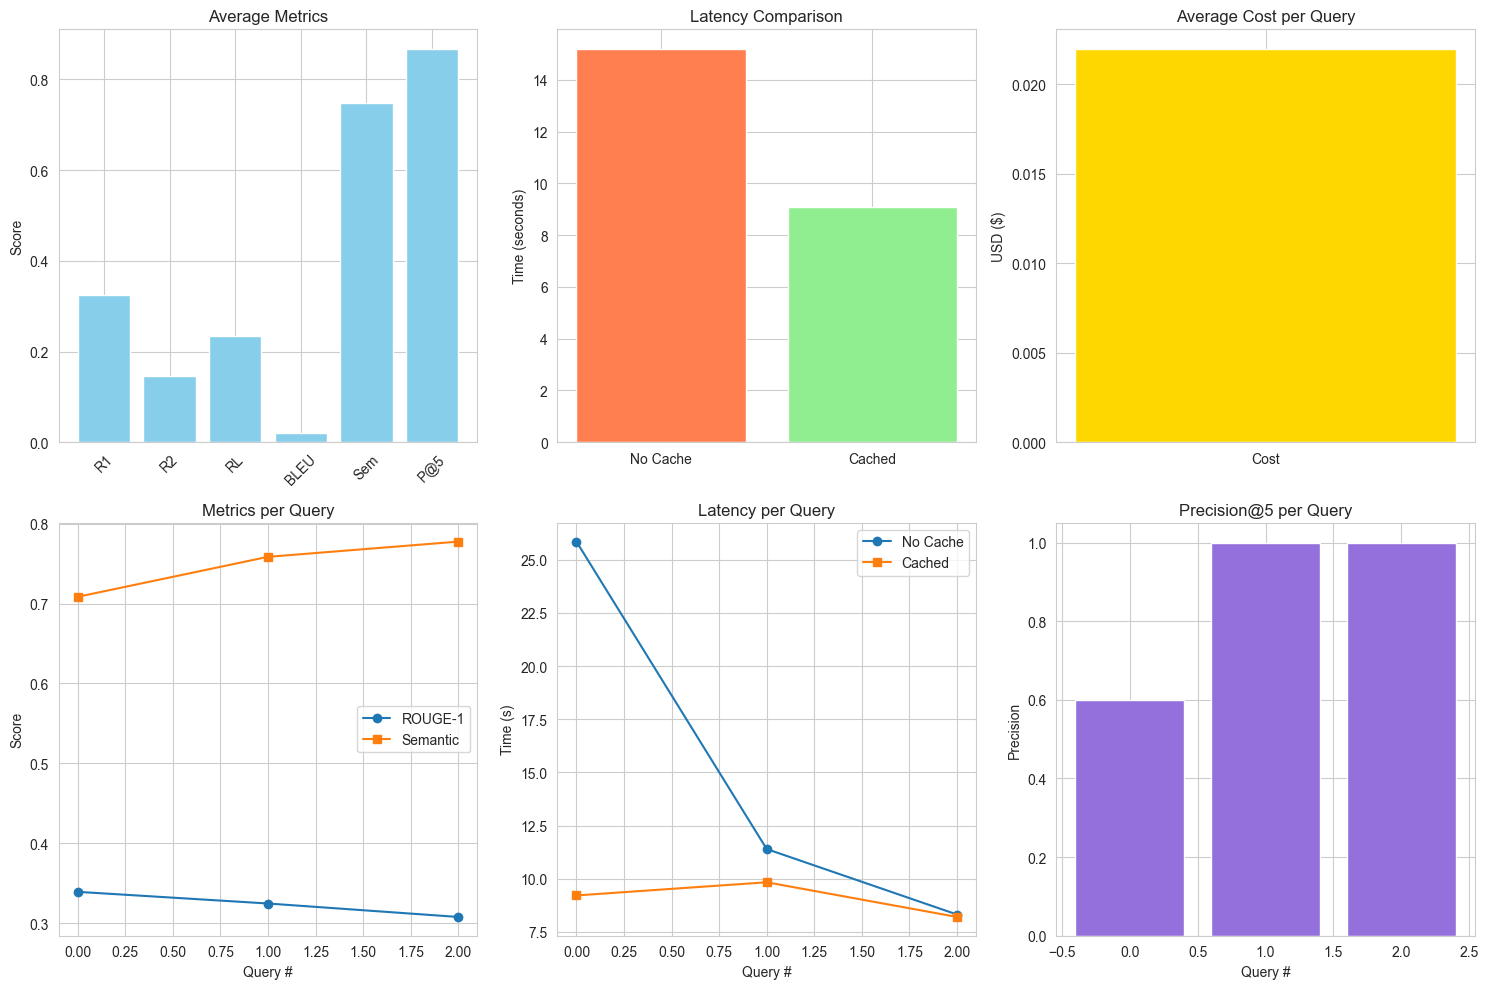

Charts saved to evaluation_charts.png


In [8]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Metric Comparison
plt.subplot(2, 3, 1)
metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'semantic_similarity', 'precision@5']
values = [df[m].mean() for m in metrics]
plt.bar(range(len(metrics)), values, color='skyblue')
plt.title('Average Metrics')
plt.ylabel('Score')
plt.xticks(range(len(metrics)), ['R1', 'R2', 'RL', 'BLEU', 'Sem', 'P@5'], rotation=45)

# 2. Latency Comparison
plt.subplot(2, 3, 2)
latencies = ['No Cache', 'Cached']
latency_values = [df['latency_no_cache_s'].mean(), df['latency_cached_s'].mean()]
plt.bar(latencies, latency_values, color=['coral', 'lightgreen'])
plt.title('Latency Comparison')
plt.ylabel('Time (seconds)')

# 3. Cost per Query
plt.subplot(2, 3, 3)
plt.bar(['Cost'], [df['cost_usd'].mean()], color='gold')
plt.title('Average Cost per Query')
plt.ylabel('USD ($)')

# 4. Per-Query Metrics
plt.subplot(2, 3, 4)
x = range(len(df))
plt.plot(x, df['rouge1'], marker='o', label='ROUGE-1')
plt.plot(x, df['semantic_similarity'], marker='s', label='Semantic')
plt.title('Metrics per Query')
plt.xlabel('Query #')
plt.ylabel('Score')
plt.legend()

# 5. Latency per Query
plt.subplot(2, 3, 5)
plt.plot(x, df['latency_no_cache_s'], marker='o', label='No Cache')
plt.plot(x, df['latency_cached_s'], marker='s', label='Cached')
plt.title('Latency per Query')
plt.xlabel('Query #')
plt.ylabel('Time (s)')
plt.legend()

# 6. Precision@5
plt.subplot(2, 3, 6)
plt.bar(x, df['precision@5'], color='mediumpurple')
plt.title('Precision@5 per Query')
plt.xlabel('Query #')
plt.ylabel('Precision')

plt.tight_layout()
plt.savefig('evaluation_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("Charts saved to evaluation_charts.png")

# Save Results

In [9]:
# Save full results
output = {
    'individual_results': results,
    'average_metrics': avg_metrics,
    'summary_table': summary_table.to_dict(),
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}

with open('evaluation_results.json', 'w') as f:
    json.dump(output, f, indent=2)

print("Full results saved to evaluation_results.json")
print("\nGenerated files:")
print("  - evaluation_summary.csv")
print("  - evaluation_charts.png")
print("  - evaluation_results.json")

Full results saved to evaluation_results.json

Generated files:
  - evaluation_summary.csv
  - evaluation_charts.png
  - evaluation_results.json
